In [21]:
import os
from deepsudoku import REPO_PATH, DIFFICULTIES

os.chdir(REPO_PATH)


# define the number of CPUs to use
from multiprocessing import Pool
from deepsudoku.generate import generate
import numpy as np
import tqdm
from hashlib import sha256
import json
import pandas as pd

In [22]:
def validate(difficulty :str):
    
    dir_path = os.path.join(REPO_PATH, "data", difficulty)
    
    input_path = [os.path.join(dir_path, i) for i in os.listdir(dir_path) if "inputs" in i]
    
    for path in tqdm.tqdm(input_path):
        
        try: 
            ar = np.load(path)
            label_path = path.replace("input","label")
            
            ar2 = np.load(label_path)
            
            assert ar.shape[1:] == (9,9), f"false shape"
            assert ar2.shape[1:] == (9,9), f"false shape"
            
        except Exception as e:
            print(path, str(e))
            
for d in DIFFICULTIES:
    validate(d)

100%|██████████| 100/100 [00:00<00:00, 2924.59it/s]


In [23]:
datasets = {}

for d in DIFFICULTIES:
    
    dir_path = os.path.join(REPO_PATH, "data", d)
    
    input_path = [os.path.join(dir_path, i) for i in os.listdir(dir_path) if "inputs" in i]
        
    labels = []
    inputs = []

    for path in tqdm.tqdm(input_path):

            ar = np.load(path)
            label_path = path.replace("input","label")
            
            ar2 = np.load(label_path)
            labels.append(ar2)        
            inputs.append(ar)        
            
    inputs = np.concatenate(inputs)
    labels = np.concatenate(labels)
    
    save_dir = os.path.join("datasets",d)
    os.makedirs(save_dir, exist_ok= True)
    
    np.save(os.path.join(save_dir, "inputs.npy"), inputs)
    np.save(os.path.join(save_dir, "labels.npy"), labels)
    
    datasets[d] = (inputs, labels)

100%|██████████| 100/100 [00:00<00:00, 2376.82it/s]


In [24]:
all_inputs = []
all_labels = []
diffs = []
indexes = []

for d,(i,l) in datasets.items():
    
    if d == "easy":
        print("Cutting Easyis")
        i = i[:250000]
        l = l[:250000]
    
    all_inputs.append(i)
    all_labels.append(l)
    diffs.append(np.array([d for _ in i]))
    indexes.append(np.arange(len(i)))

all_inputs = np.concatenate(all_inputs)
all_labels = np.concatenate(all_labels)
diffs = np.concatenate(diffs)
indexes = np.concatenate(indexes)

np.save("datasets/all_inputs.npy", all_inputs)
np.save("datasets/all_labels.npy", all_labels)

Cutting Easyis


In [25]:
df = pd.DataFrame({"index": indexes, "difficulty": diffs})

df["input_sha"] = [sha256(ar).hexdigest() for ar in tqdm.tqdm(all_inputs)]
df["label_sha"] = [sha256(ar).hexdigest() for ar in tqdm.tqdm(all_labels)]

100%|██████████| 1825000/1825000 [00:01<00:00, 1126836.33it/s]


In [26]:
df.groupby("difficulty")["index"].count()

difficulty
easy       250000
extreme    290000
hard       250000
insane     500000
medium     535000
Name: index, dtype: int64

<Axes: ylabel='Frequency'>

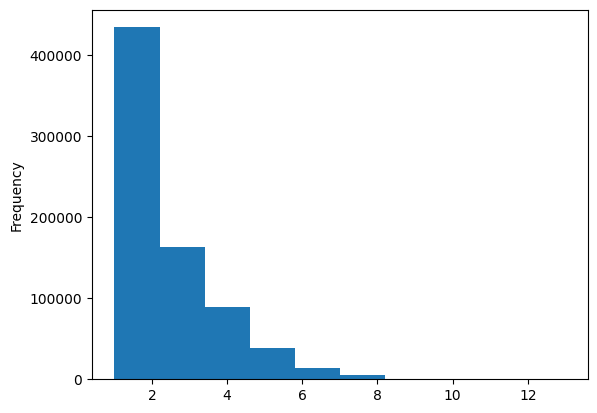

In [27]:
value_counts = df.value_counts(["label_sha"])
value_counts.plot.hist()

<Axes: ylabel='Frequency'>

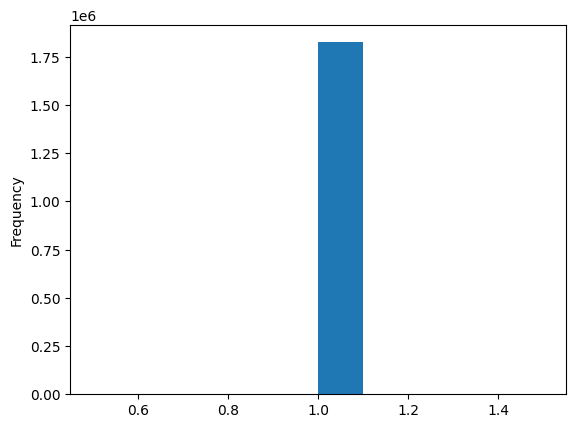

In [28]:
value_counts = df.value_counts(["input_sha"])
value_counts.plot.hist()

<Axes: ylabel='count'>

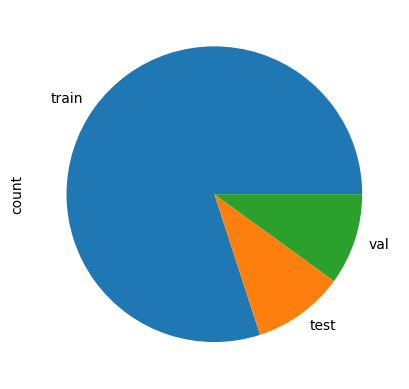

In [29]:
df["data_type"] = "train"

for d in df.difficulty.unique():
    
    k = df.query("difficulty == @d")
    
    first_ten = int(len(k)/ 10)

    df.loc[k.index[:first_ten],"data_type"] = "test"
    df.loc[k.index[first_ten: first_ten * 2],"data_type"] = "val"
    
df["data_type"].value_counts().plot.pie()

In [30]:
df.to_feather("datasets/info.feather")